In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer

from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import \
    mean_squared_error as mse, \
    f1_score as f1, \
    roc_auc_score as roc_auc, \
    confusion_matrix, \
    classification_report, \
    precision_recall_curve, \
    roc_curve

In [3]:
train = pd.read_csv("train.csv")

y = train["Survived"]
X = train.drop(columns=["PassengerId", "Survived"])
X

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
class AgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, step_of_partitions=10, mode="r"):
        self.mode = mode
        self.step_of_partitions = step_of_partitions
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        
        ages = [x for x in range(self.step_of_partitions, int(X_copy.Age.max())+self.step_of_partitions, self.step_of_partitions)]
        for step in ages:
            X_copy.Age.mask(((X_copy.Age > step-self.step_of_partitions) & (X_copy.Age <= step)), step, inplace=True)
        
        if self.mode == "r":
            X_copy.loc[:, 'Age'] = X_copy.Age.apply(lambda x: random.choice(ages) if np.isnan(x) else x)

        if self.mode == "s":
            counts = X_copy.Age.value_counts(normalize=True).round(3).sort_index()
            
            ages = counts.index.values
            weights = counts.values
            
            X_copy.loc[:, 'Age'] = X_copy.Age.apply(lambda x: random.choices(ages, weights, k=1)[0] if np.isnan(x) else x)

        return X_copy

In [5]:
class FamilyRelationshipTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        
        X_copy.loc[:, 'SibSp'] = X_copy["SibSp"].apply(lambda x: 0 if (x == 0 or x >= 2) else 1)
        X_copy.loc[:, 'Parch'] = X_copy["Parch"].apply(lambda x: 0 if (x == 0 or x >= 2) else 1)
        
        X_copy["FamTies"] = X_copy.SibSp + X_copy.Parch
        X_copy.drop(columns=["SibSp", "Parch"], inplace=True)
        
        return X_copy

In [6]:
estimators = [
    ("age-transformer", AgeTransformer(step_of_partitions=10, mode="s")),
    ("family_relationship-transformer", FamilyRelationshipTransformer()),
    ("imputer", SimpleImputer(strategy="most_frequent")), 
    ("encoder", OrdinalEncoder()), 
]

In [7]:
prepare_pipe = Pipeline(estimators)
X_ = prepare_pipe.fit_transform(X[["Pclass", "Sex", "Age", "SibSp", "Parch"]])

X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.15, random_state=42)

### K-блочная перекрёстная проверка

In [8]:
folds = KFold(n_splits=10, shuffle=True)

#model = LogisticRegression()
scores = cross_val_score(model, X_, y, cv=folds)
print(f"Значения правильности перекрестной проверки: {scores}")
print(f"Средняя правильность перекрестной проверки: {scores.mean()}")

NameError: name 'model' is not defined

### Перекрёстная проверка с исключением одного

In [249]:
folds = LeaveOneOut()

#model = LogisticRegression()
scores = cross_val_score(model, X_, y, cv=folds)
print(f"Кол-во итераций перекрестной проверки: {len(scores)}")
print(f"Средняя правильность перекрестной проверки: {scores.mean()}")

Кол-во итераций перекрестной проверки: 891
Средняя правильность перекрестной проверки: 0.7856341189674523


### Перекрёстная проверка со случайными перестановками при разбиении

In [250]:
folds = ShuffleSplit(test_size=0.5, train_size=0.5, n_splits=100)

#model = LogisticRegression()
scores = cross_val_score(model, X_, y, cv=folds)
print(f"Кол-во итераций перекрестной проверки: {len(scores)}")
print(f"Средняя правильность перекрестной проверки: {scores.mean()}")

Кол-во итераций перекрестной проверки: 100
Средняя правильность перекрестной проверки: 0.787152466367713


### Решётчатый поиск

Предварительно были проверены варианты различных алгоритмов на ограниченном диапазоне итераций обучения, после чего был выбран алгоритм LIBLINEAR. После применялась более детальная настройка гиперпараметров с последующим анализом лучшего пересечения (см. график).

For solver `liblinear` find {'C': 5.0, 'penalty': 'l1', 'solver': 'liblinear'} with best score 0.7058144208240307


/home/pogramist/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pogramist/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pogramist/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_params()
  File "/home/pogramist/.local/lib/python3.8/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/

<AxesSubplot: xlabel='param_C', ylabel='param_penalty'>

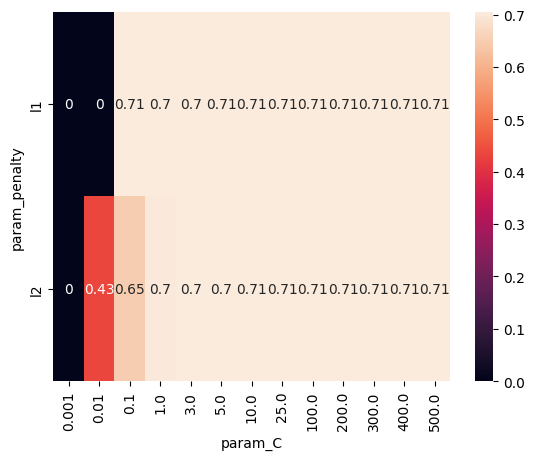

In [16]:
parameters = {
    "penalty": ["l1", "l2"], 
    "solver": ["liblinear"], 
    "C": [0, 000.1, 0.001, 0.01, 0.01, 1., 3., 5., 10., 25., 100., 200., 300., 400., 500.]
}

model = LogisticRegression(random_state=42)

grid = GridSearchCV(model, parameters, cv=10, scoring="f1")
grid.fit(X_train, y_train)

print(f"For solver `liblinear` find {grid.best_params_} with best score {grid.best_score_}", end="\n")

results = pd.DataFrame(grid.cv_results_)


scores = results.pivot_table(
    index="param_penalty", 
    columns="param_C", 
    values="mean_test_score",
    aggfunc=np.mean
)

sns.heatmap(scores, annot=True)

In [10]:
model = grid.best_estimator_

### Точность/полнота и F1 мера

In [11]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Death", "Survived"]))

              precision    recall  f1-score   support

       Death       0.81      0.86      0.83        78
    Survived       0.78      0.71      0.75        56

    accuracy                           0.80       134
   macro avg       0.80      0.79      0.79       134
weighted avg       0.80      0.80      0.80       134



In [12]:
confusion_matrix(y_test, y_pred)

array([[67, 11],
       [16, 40]])

### PR-кривые и ROC AUC

Text(0, 0.5, 'Полнота')

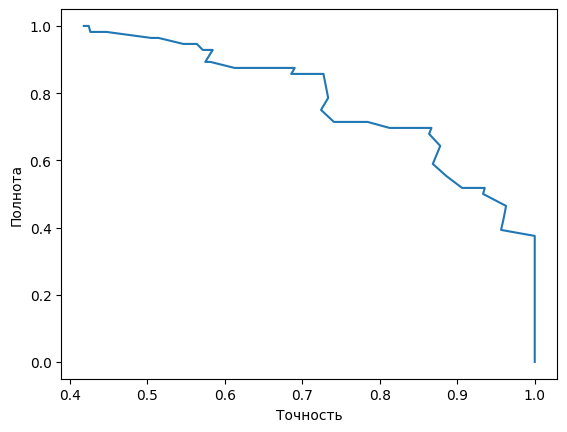

In [13]:
model.fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(y_test, model.decision_function(X_test))
plt.plot(precision, recall)
plt.xlabel("Точность")
plt.ylabel("Полнота")

Text(0, 0.5, 'TPR (полнота)')

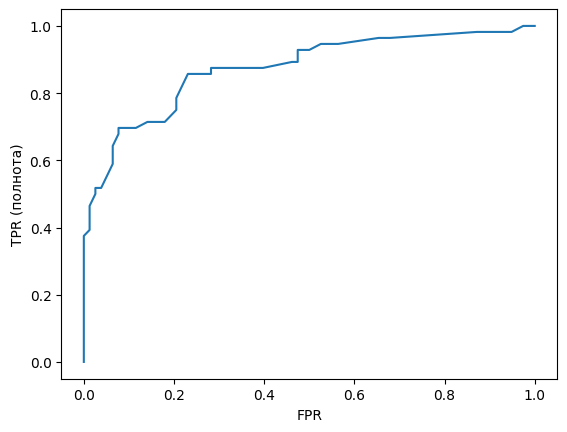

In [14]:
model = LogisticRegression(C=5.0, penalty='l2', solver='liblinear')

model.fit(X_train, y_train)

fpr, tpr, thresholds = roc_curve(y_test, model.decision_function(X_test))
plt.plot(fpr, tpr, label="ROC-кривая")
plt.xlabel("FPR")
plt.ylabel("TPR (полнота)")

### Анализ коэффициентов

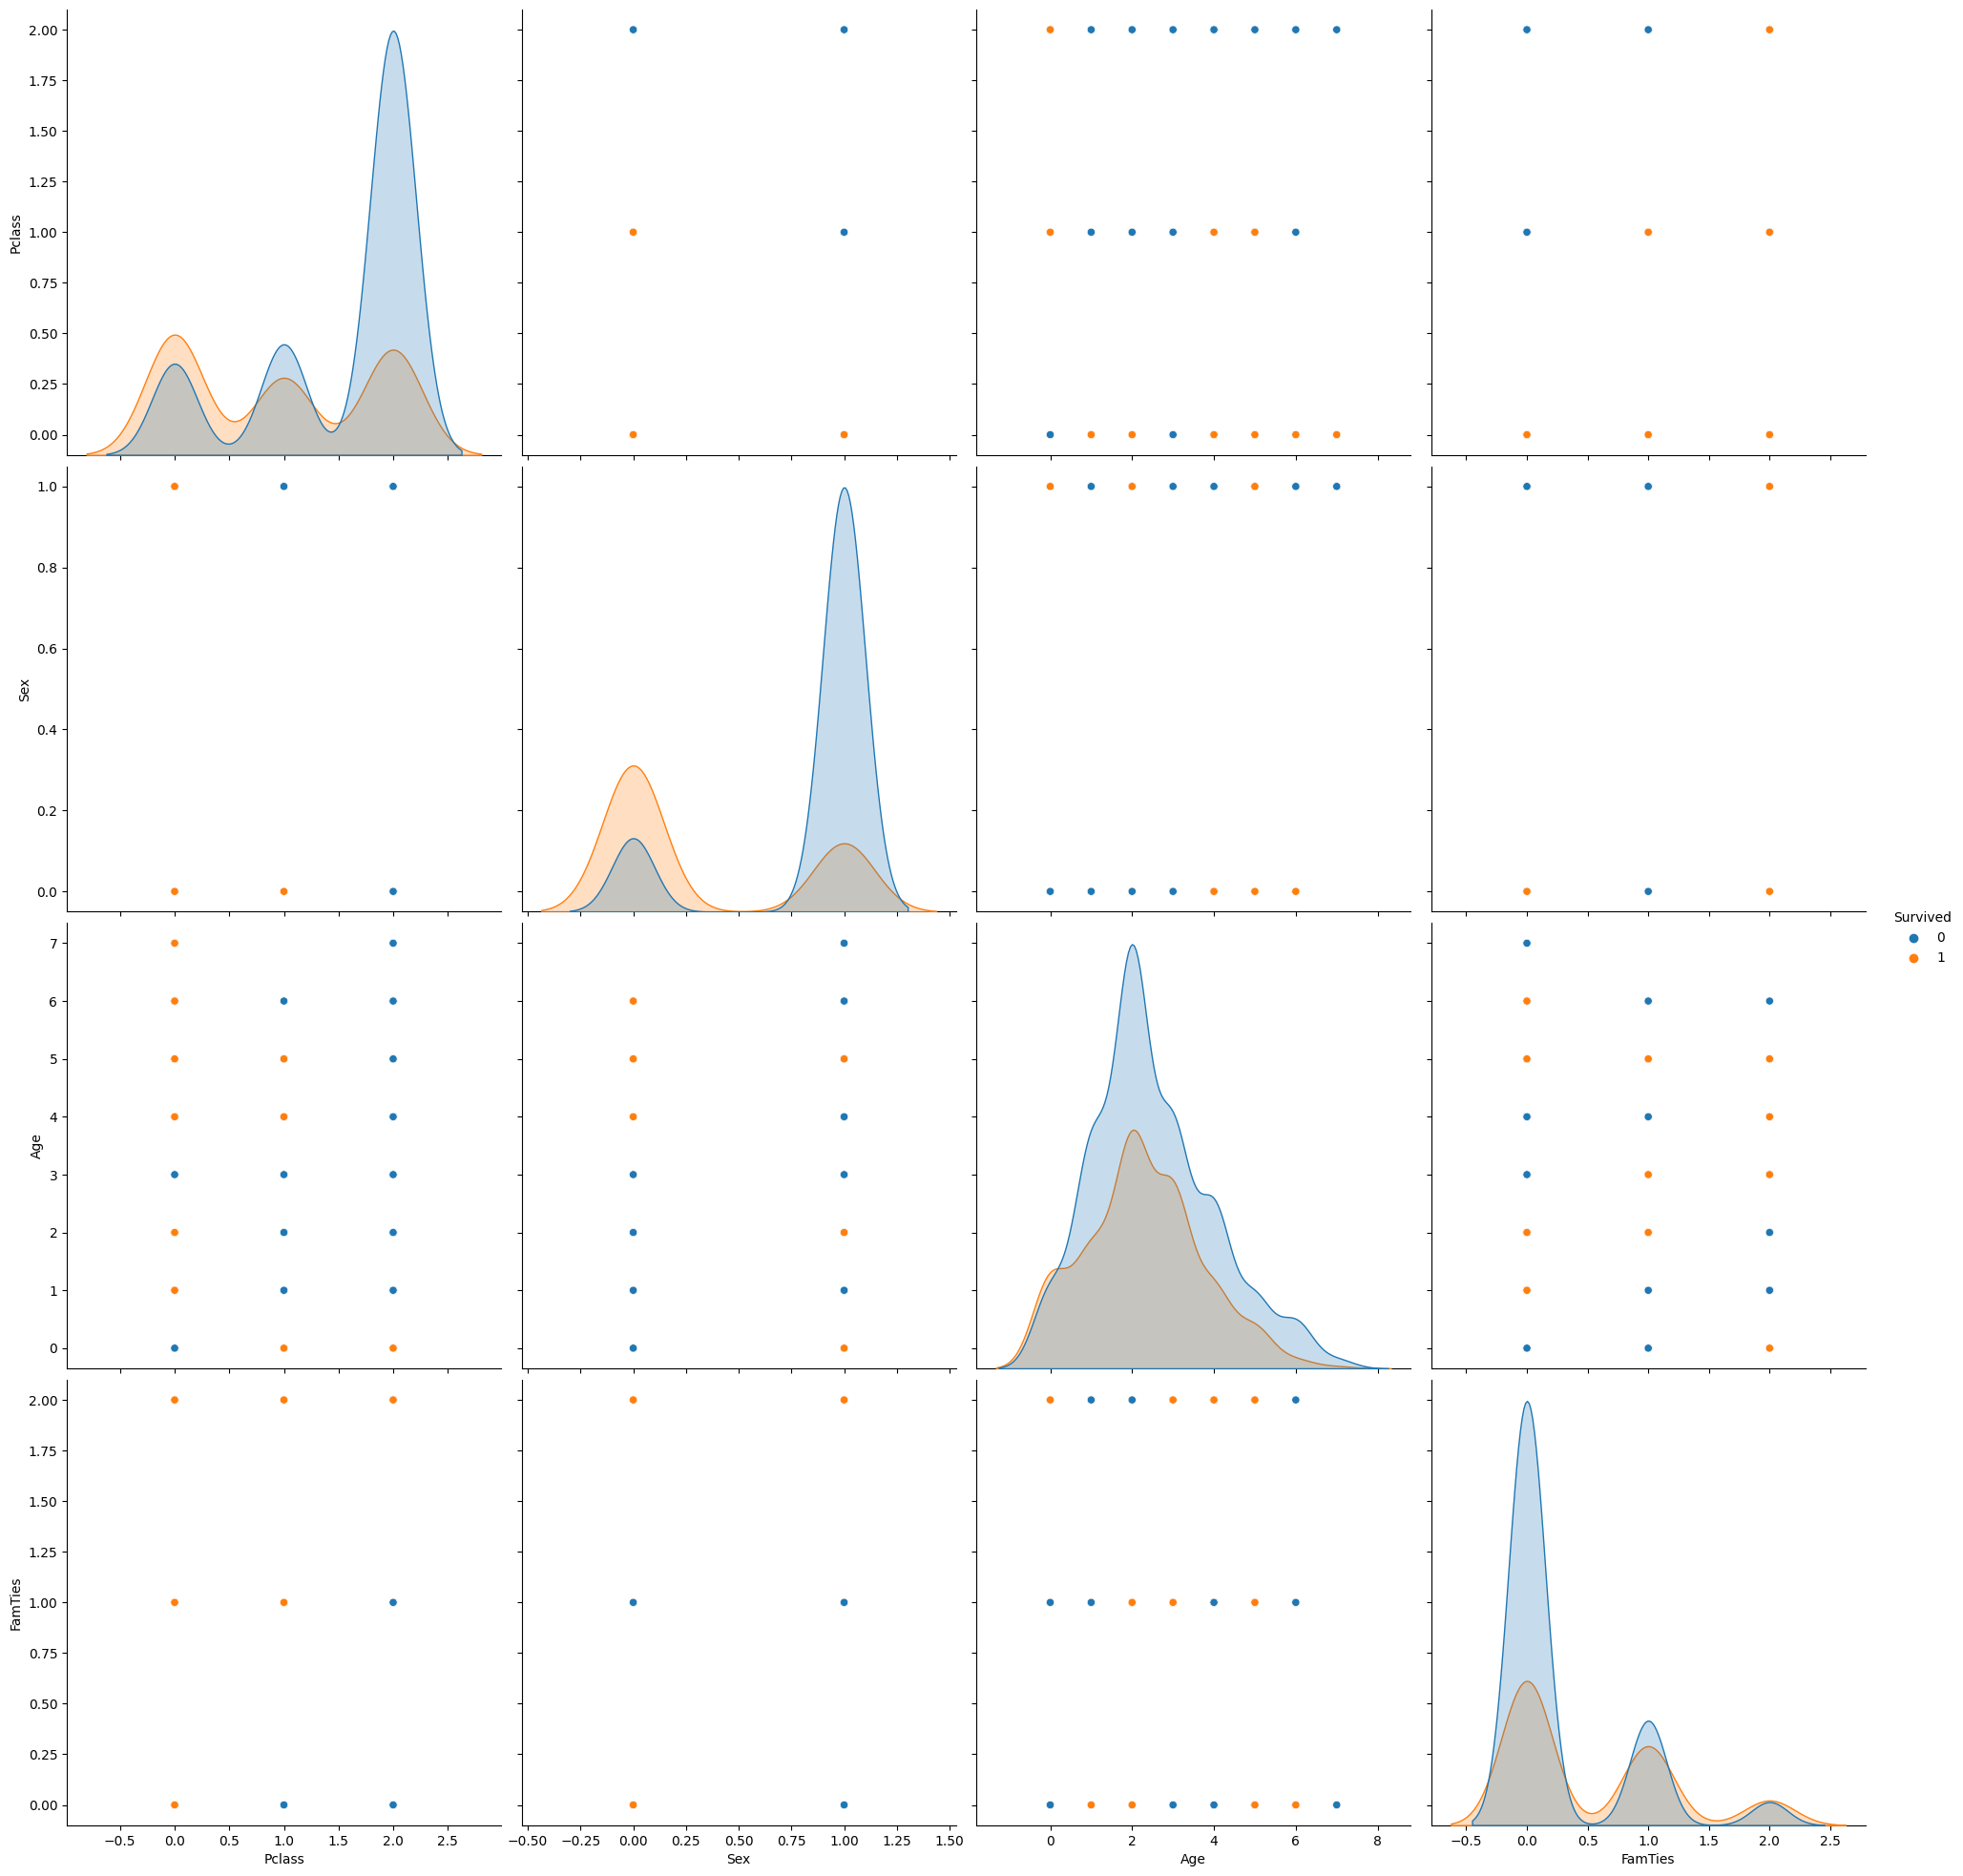

In [15]:
# Порядок: Pclass Sex Age FamTies
analyze_data = pd.DataFrame(X_, columns=["Pclass", "Sex", "Age", "FamTies"])
analyze_data["Survived"] = y
analyze_data

# sns.lmplot(analyze_data, x="Pclass", y="FamTies", hue="Survived")
sns.pairplot(analyze_data, hue="Survived", height=5)

In [35]:
# Возникли неожиданные warning-и, необходимо дополнительно разбираться с ними для использования
'''
    "newton_cholesky": {
        "penalty": ["l2", None], 
        "solver": ["newton-cholesky"], 
        "max_iter": [x for x in range(100, 1000, 100)]
    },
    "saga": {
        "penalty": ["l1", "l2", "elasticnet", None], 
        "solver": ["saga"], 
        "max_iter": [x for x in range(4000, 6000, 100)]
    }
'''

'\n    "newton_cholesky": {\n        "penalty": ["l2", None], \n        "solver": ["newton-cholesky"], \n        "max_iter": [x for x in range(100, 1000, 100)]\n    },\n    "saga": {\n        "penalty": ["l1", "l2", "elasticnet", None], \n        "solver": ["saga"], \n        "max_iter": [x for x in range(4000, 6000, 100)]\n    }\n'

### Статус
1. Решётчатый поиск: найдены оптимальные гиперпараметры.
2. Оценка качества модели: получены основные метрики и кривые качества (PR Curve|ROC AUC), результат качества модель на проверочном наборе приблизительно 75-78 процентов.
3. Коэффициенты модели: анализ коэффициентов модели наталкивает на мысль, что ввиду строгих правил обработки данных линейный (либо любой другой) паттерн не прослеживается и с использованием логистической регрессии данные показатели - максимально возможные.